### PAIR XI MÓDULO 3: Decision Tree
Para los ejercicios de Pair hemos utilizado el siguiente dataset: [Spotify Tracks Dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset)

In [12]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal. El objetivo de hoy es:
- Ajustar el modelo a un Decision Tree
- Extraer las métricas
- Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas)

In [13]:
df = pd.read_pickle('data/spotify_songs_estandarizado_encoding.pkl')
df.head(2)

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,owners_F_G,owners_G,owners_G_A,owners_major,owners_minor,owners_compas_1,owners_compas_2,owners_compas_3,owners_compas_4,owners_compas_5
0,18,-0.184255,-0.157447,0.025974,-0.153345,4.038855,-0.065621,-0.000916,0.100897,-0.102381,...,0,0,0,0,1,0,0,0,1,0
1,58,-0.832951,0.612766,-0.194805,0.225755,7.351738,-0.116098,-0.000916,-0.266256,-0.038095,...,0,1,0,1,0,0,0,0,1,0


In [15]:
X = df.drop("popularity", axis = 1)
y = df["popularity"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

arbol = DecisionTreeRegressor(random_state =0)

arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [16]:
#Vamos a crear la función de métricas
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [17]:
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree_sin hiperp")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,20.486973,773.61742,27.813979,-0.571561,test,Decission Tree_sin hiperp
1,0.227140,7.12125,2.668567,0.985739,train,Decission Tree_sin hiperp


In [18]:
df.head(2)

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,owners_F_G,owners_G,owners_G_A,owners_major,owners_minor,owners_compas_1,owners_compas_2,owners_compas_3,owners_compas_4,owners_compas_5
0,18,-0.184255,-0.157447,0.025974,-0.153345,4.038855,-0.065621,-0.000916,0.100897,-0.102381,...,0,0,0,0,1,0,0,0,1,0
1,58,-0.832951,0.612766,-0.194805,0.225755,7.351738,-0.116098,-0.000916,-0.266256,-0.038095,...,0,1,0,1,0,0,0,0,1,0


In [19]:
#Vamos a juntar los datos con el de regresión lineal:

df_resultados_rl = pd.read_csv("data/resultados_spotify.csv")

df_decision_results = pd.concat([df_resultados_rl, dt_results1], axis = 0)

df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,18.232066,475.870761,21.814462,0.033295,test,Linear Regresion
1,18.388840,485.864750,22.042340,0.027021,train,Linear Regresion
0,20.486973,773.617420,27.813979,-0.571561,test,Decission Tree_sin hiperp
1,0.227140,7.121250,2.668567,0.985739,train,Decission Tree_sin hiperp


Como ya habíamos visto, nuestras métricas han salido completamente overfitting (métricas de train perfectas y no tan buenas de test (63% de valores predichos por las VP)). 
Vamos a ajustar ahora los hiperparámetros:

In [20]:
# Vamos a comprobar nuestros datos para ver qué parametros indicar:
max_features = np.sqrt(len(x_train.columns))
print(f"max_features: {max_features.round(2)}")
print(f"max_depth: {arbol.tree_.max_depth}")
print(f"df_shape: {df.shape}")

max_features: 5.57
max_depth: 43
df_shape: (12000, 32)


In [21]:
param = {"max_depth": [2, 4, 6, 8, 12, 25], # Hemos reducido mucho el max_depth porque el modelo anterior ha salido completamente overfitting
        "max_features": [1, 2, 3, 4, 5,6],
        "min_samples_split": [50, 100, 200, 300, 400, 500],
        "min_samples_leaf": [50, 100, 200, 300, 400]} 

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(),
            param_grid= param, 
            cv=10,
            verbose=0,
            return_train_score = True, 
            scoring="neg_mean_squared_error")

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 12, 25],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [50, 100, 200, 300, 400],
                         'min_samples_split': [50, 100, 200, 300, 400, 500]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [22]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=12, max_features=6, min_samples_leaf=100,
                      min_samples_split=300)

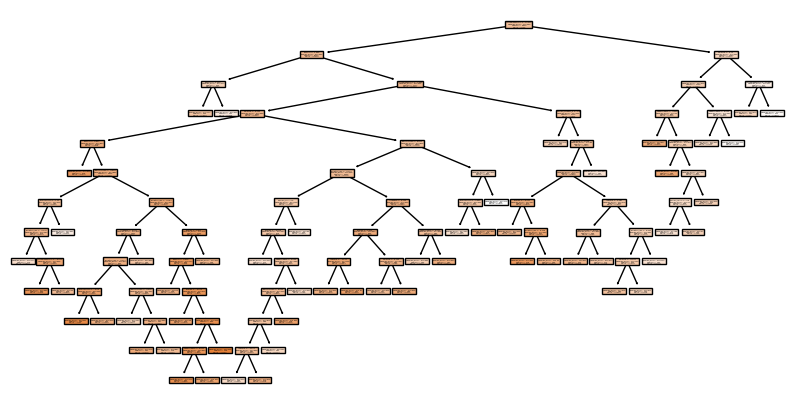

In [23]:
# Por curiosidad, vamos a ver cómo queda nuestro árbol:

fig = plt.figure(figsize=(10, 5))
tree.plot_tree(mejor_modelo, feature_names=list(x_train.columns), filled=True);

In [24]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,18.029347,470.405022,21.688823,0.044398,test,Decision tree II
1,17.803552,461.850772,21.490714,0.075111,train,Decision tree II


In [25]:
df_decision_results = pd.concat([df_decision_results, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,18.232066,475.870761,21.814462,0.033295,test,Linear Regresion
1,18.388840,485.864750,22.042340,0.027021,train,Linear Regresion
0,20.486973,773.617420,27.813979,-0.571561,test,Decission Tree_sin hiperp
1,0.227140,7.121250,2.668567,0.985739,train,Decission Tree_sin hiperp
0,18.029347,470.405022,21.688823,0.044398,test,Decision tree II
1,17.803552,461.850772,21.490714,0.075111,train,Decision tree II


En este caso, los resultados siguen siendo muy malos, nuestra VR solo está explicada en un 4% por las VP, lo que provoca que nuestro modelo se esté equivocando la predicción en casi 22 puntos.

In [26]:
df_decision_results.to_csv("data/resultados_spotify.csv", index=False)